I had a lot of trouble here when working with individual structures.

When using nearest interpolation the gradient is 0.

I had to pull the target back, then update the atlas image with contrast transform.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
import glob
import torch

from scipy.stats import rankdata
import nrrd
import time

In [2]:
dtype = torch.float
device = 'cpu'
#device = 'cuda:0'

In [3]:
files = glob.glob('/mnt/data/merfish/OneDrive_1_8-5-2021/*metadata*.csv.gz')
files.sort()

In [4]:
files = [files[0]]

In [5]:
# now we will use torch
import torch
from torch.nn.functional import grid_sample
# build an interp function from grid sample
def interp(x,I,phii,**kwargs):
    '''
    Interpolate the image I, with regular grid positions stored in x (1d arrays),
    at the positions stored in phii (3D arrays with first channel storing component)
    '''
    # first we have to normalize phii to the range -1,1    
    I = torch.as_tensor(I)
    phii = torch.as_tensor(phii)
    phii = torch.clone(phii)
    for i in range(3):
        phii[i] -= x[i][0]
        phii[i] /= x[i][-1] - x[i][0]
    # note the above maps to 0,1
    phii *= 2.0
    # to 0 2
    phii -= 1.0
    # done

    # NOTE I should check that I can reproduce identity
    # note that phii must now store x,y,z along last axis
    # is this the right order?
    # I need to put batch (none) along first axis
    # what order do the other 3 need to be in?    
    out = grid_sample(I[None],phii.flip(0).permute((1,2,3,0))[None],align_corners=True,**kwargs)
    # note align corners true means square voxels with points at their centers
    # post processing, get rid of batch dimension

    return out[0]

In [6]:
# timesteps will be along the first axis
def v_to_phii(xv,v):
    '''
    Inputs: 
        xv -> list of 1D tensors describing locations of sample points
        v -> 5D (nt,3,v0,v1,v2) velocity field
    Output:
        phii (inverse map) computed by method of characteristics

    '''
    XV = torch.stack(torch.meshgrid(xv))
    phii = torch.clone(XV)
    dt = 1.0/v.shape[0]
    for t in range(v.shape[0]):
        Xs = XV - v[t]*dt
        phii = interp(xv,phii-XV,Xs)+Xs
    return phii

In [7]:
def to_A(L,T):
    O = torch.tensor([0.,0.,0.,1.],device=L.device,dtype=L.dtype)
    return torch.cat((torch.cat((L,T[:,None]),1),O[None]))

<IPython.core.display.Javascript object>


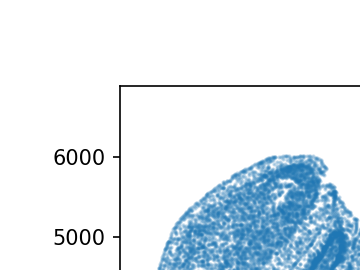

(140, 199)


<IPython.core.display.Javascript object>


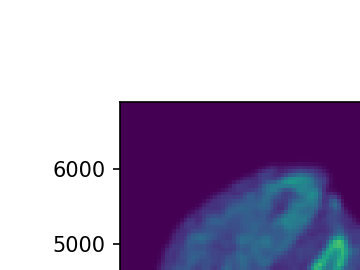

0 of 78329
10000 of 78329
20000 of 78329
30000 of 78329
40000 of 78329
50000 of 78329
60000 of 78329
70000 of 78329
78328 of 78329
350 -0.17453292519943295


<IPython.core.display.Javascript object>


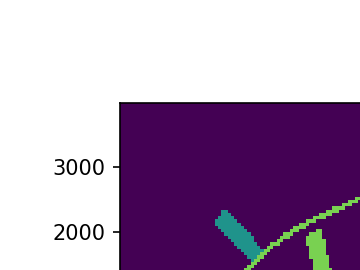

<IPython.core.display.Javascript object>


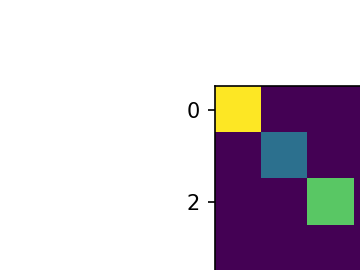

<IPython.core.display.Javascript object>


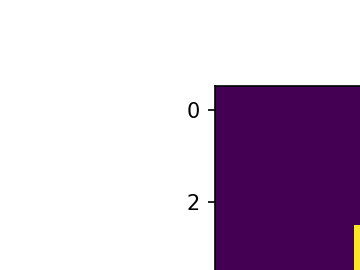

tensor([[ 1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.9848,  0.1736],
        [ 0.0000, -0.1736,  0.9848]], requires_grad=True) tensor([-2175.,  4000.,  5000.], requires_grad=True)
tensor([[ 1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.9848,  0.1736],
        [ 0.0000, -0.1736,  0.9848]], requires_grad=True) tensor([-2175.,  4000.,  5000.], requires_grad=True)


<IPython.core.display.Javascript object>


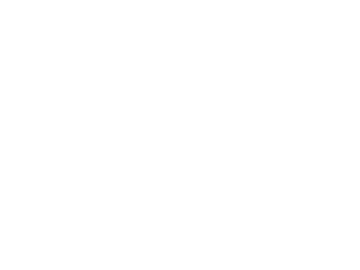

<IPython.core.display.Javascript object>


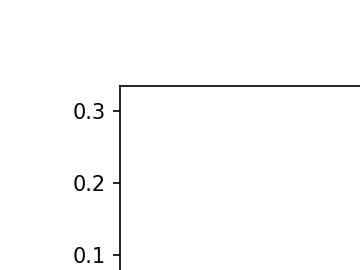

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/torch/autograd/__init__.py:149: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /pytorch/aten/src/ATen/native/Copy.cpp:240.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:333: UserWarning: No contour levels were found within the data range.


<IPython.core.display.Javascript object>


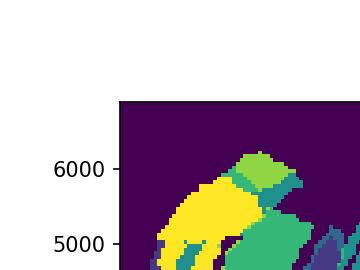

In [8]:
for fname in files:
    #if 'structure_id' in fname: continue
    #fname = '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_cell_by_gene_S1R1.csv.gz'



    names = os.path.splitext(fname)
    if names[1] == '.gz':
        names = os.path.splitext(names[0])
    outname = names[0] + '_with_structure_id_v02.csv'
    
    
    df = pd.read_csv(fname.replace('by_gene','metadata'))
    x = np.array(df['center_x'])
    y = np.array(df['center_y'])
    v = np.array(df['volume'])
    N = x.shape[0]
    mat = np.array([[9.20788192749023E+00, 0E+00, -3.77225189208984E+02],
                [0E+00, 9.20783615112305E+00, 9.39383850097656E+02],
                [0E+00, 0E+00, 1E+00 ]])
    mat = np.eye(3)
    xy = np.stack((x,y),0)
    xy = mat[:2,:2]@xy + mat[:2,-1][:,None]
    x,y = xy
    f,ax = plt.subplots()
    ax.scatter(x,y,s=1,alpha=0.25)
    #ax.invert_yaxis()
    # what are the units in xy
    # they should be microns
    # they're probably pixel, the conversion factor is
    f.canvas.draw()
    
    
    # now we want to rasterize
    minx = np.min(x)
    maxx = np.max(x)
    miny = np.min(y)
    maxy = np.max(y)
    expand = 1.1
    minx,maxx = (minx+maxx)/2.0 - (maxx-minx)/2.0*expand, (minx+maxx)/2.0 + (maxx-minx)/2.0*expand
    miny,maxy = (miny+maxy)/2.0 - (maxy-miny)/2.0*expand, (miny+maxy)/2.0 + (maxy-miny)/2.0*expand

    dx = 50 # I will register to 50 micron atlas
    X_ = np.arange(minx,maxx,dx)
    Y_ = np.arange(miny,maxy,dx)
    X = np.stack(np.meshgrid(X_,Y_))
    blur = 0.75 # gaussian std in voxels
    blur = 1.0
    W = np.zeros((len(Y_),len(X_)))
    print(W.shape)
    
    
    f,ax = plt.subplots()
    count = 0
    for x_,y_ in zip(x,y):
        # to speed things up I shoul index
        # to do this I'd have to find row and column indices
        col = np.round((x_ - X_[0])/dx).astype(int)
        row = np.round((y_ - X_[1])/dx).astype(int)
        row0 = np.floor(row-blur*3).astype(int)
        row1 = np.ceil(row+blur*3).astype(int)
        rows = np.arange(row0,row1+1)
        #rows = np.arange(row,row+blur*3+1)
        #rows_ = np.arange(row,row-blur*3-1,-1)
        #rows__ = np.concatenate((rows_[::-1],rows[1:])).astype(int)
        #cols = np.arange(col,col+blur*3+1)
        #cols_ = np.arange(col,col-blur*3-1,-1)
        #cols__ = np.concatenate((cols_[::-1],cols[1:])).astype(int)

        ## this step is incrementing one pixel at a time, it is way way faster
        #I[c_,row,col] += 1.0
        #W[row,col] += 1.0

        k = np.exp( - ( (X[0] - x_)**2 + (X[1] - y_)**2 )/(2.0*(dx*blur)**2)  )
        k /= np.sum(k)
        #I[c_] += k 
        W += k

        if not count%10000 or count==(x.shape[0]-1):
            print(f'{count} of {x.shape[0]}')

            ax.cla()
            ax.imshow(W)
            f.canvas.draw()

        count += 1
        
    extent = (X_[0],X_[-1],Y_[0],Y_[-1])
    ax.cla()
    ax.imshow(W,  origin='lower',extent=extent)
    f.canvas.draw()
    f.savefig(outname[:-4]+'_image.png')
    
    # start by loading the atlas
    
    imagefile = '/home/dtward/data/AllenInstitute/ara_nissl/ara_nissl_50.nrrd'
    imagefile = '/home/dtward/data/AllenInstitute/mouse_ccf/annotation/ccf_2017/annotation_50.nrrd'
    vol,hdr = nrrd.read(imagefile)
    A = vol
    #A = rankdata(A).reshape(A.shape) # this isn't exactly what I want
    #f,ax = plt.subplots()
    #ax.imshow(A[50])

    labelfile = '/home/dtward/data/AllenInstitute/mouse_ccf/annotation/ccf_2017/annotation_50.nrrd'
    vol,hdr = nrrd.read(labelfile)
    L = vol
    #f,ax = plt.subplots()
    #ax.imshow(L[50]%7)

    dxA = np.diag(hdr['space directions'])
    nxA = A.shape
    xA = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxA,dxA)]
    XA = np.meshgrid(*xA,indexing='ij')
    
    # we need to get a slice for each
    theta0 = 0.0
    if 'S1R1' in fname:
        slice_ = 350
        theta0 = -10.0*np.pi/180 # negative rotates counter clockwise
    elif 'S1R2' in fname:
        slice_ = 350
        theta0 = 45.0*np.pi/180
    elif 'S1R3' in fname:
        slice_ = 350
        theta0 = 45.0*np.pi/180
    elif 'S2R1' in fname:
        slice_ = 270
        theta0 = -10.0*np.pi/180
    elif 'S2R2' in fname:
        slice_ = 270
        theta0 = -(90+45)*np.pi/180
    elif 'S2R3' in fname:
        slice_ = 270
        theta0 = 180*np.pi/180
    elif 'S3R1' in fname:
        slice_ = 180
        theta0 = 45*np.pi/180
    elif 'S3R2' in fname:
        slice_ = 180
        theta0 = 0.0
    elif 'S3R3' in fname:
        slice_ = 180
        theta0 = -(90+45)*np.pi/180
    print(slice_,theta0)
        
    f,ax = plt.subplots()
    ax.imshow(A[slice_//2],extent=[xA[2][0],xA[2][-1],xA[1][0],xA[1][-1]])
    
    
    


    #I = torch.as_tensor(A[None]/np.mean(np.abs(A)),dtype=dtype,device=device)
    I = torch.as_tensor(A[None].astype(np.int64),dtype=dtype,device=device) # for label
    J = torch.as_tensor(W[None,None]/np.mean(np.abs(W)),dtype=dtype,device=device)
    xI = [torch.as_tensor(x,dtype=dtype,device=device) for x in xA]
    xJ = [torch.as_tensor([0.0],device=device,dtype=dtype),
          torch.as_tensor(Y_,device=device,dtype=dtype),
          torch.as_tensor(X_,device=device,dtype=dtype)]
    XJ = torch.stack(torch.meshgrid(xJ),-1)
    XI = torch.stack(torch.meshgrid(xI),-1)
    
    # velocity
    dI = torch.tensor([x[1]-x[0] for x in xI])
    #xv = [x[::2] for x in xI]
    #dv = torch.tensor([x[1]-x[0] for x in xv])
    dv = dI*3
    buf = 20
    xv = [torch.arange(x[0]-dIi*buf,x[-1]+dIi*buf,dvi) for x,dIi,dvi in zip(xI,dI,dv)]
    a = dv[0]*3.0
    p = 2.0
    nv = torch.tensor([len(x) for x in xv])
    XV = torch.stack(torch.meshgrid(xv),-1)
    fv = [torch.arange(n)/d/n for n,d in zip(nv,dv)]
    FV = torch.stack(torch.meshgrid(fv),-1)
    LL = (1.0 - 2.0*a**2 * 
                  ( (torch.cos(2.0*np.pi*FV[...,0]*dv[0]) - 1)/dv[0]**2  
                + (torch.cos(2.0*np.pi*FV[...,1]*dv[1]) - 1)/dv[1]**2  
                + (torch.cos(2.0*np.pi*FV[...,2]*dv[2]) - 1)/dv[2]**2   ) )**(p*2)
    K = 1.0/LL
    
    
    
    
    
    # metric
    # we'll use the pullback on the points in the atlas
    
    if 'g' not in globals(): # only need to do this once
        g = torch.zeros((12,12))
        count = 0
        for i in range(12):
            Ei = (torch.arange(16)==i).reshape((4,4))*1.0
            EiXI = (Ei[:3,:3]@XI[...,None])[...,0] + Ei[:3,-1]
            for j in range(12):
                Ej = (torch.arange(16)==j).reshape((4,4))*1.0
                EjXI = (Ej[:3,:3]@XI[...,None])[...,0] + Ej[:3,-1]
                g[i,j] = torch.mean(torch.sum(EiXI*EjXI,-1))


            
    gi = torch.inverse(g)
    f,ax = plt.subplots()
    ax.imshow(g)
    #ax.imshow(torch.log(torch.abs(g))*torch.sign(g))
    f.canvas.draw()

    f,ax = plt.subplots()
    ax.imshow(gi)
    #ax.imshow(torch.log(torch.abs(g))*torch.sign(g))
    f.canvas.draw()

    
    # affine matrix 
    L = torch.eye(3,device=device, dtype=dtype, requires_grad=True)
    #L.data[1,1] = -1
    L.data[1,1] = np.cos(theta0)
    L.data[2,1] = np.sin(theta0)
    L.data[1,2] = -np.sin(theta0)
    L.data[2,2] = np.cos(theta0)
    T = torch.zeros(3,device=device,dtype=dtype, requires_grad=True)
    T.data[0] = -xI[0][slice_//2]
    T.data[1] = 4000
    T.data[2] = 5000
    print(L,T)
    #T.data[2] = 6000 # less good but double checking T
    #L.data = torch.tensor([[ 0.9997, -0.0089, -0.0033],
    #        [ 0.0017, -0.8628, -0.2064],
    #        [-0.0044, -0.2312,  0.8307]])
    #T.data = torch.tensor([ -166.5568, -3948.2505,  4890.3770])
    print(L,T)

    
    nt = 2
    v = torch.zeros((nt,nv[0],nv[1],nv[2],3),requires_grad=True)
    
    
    f0,ax0 = plt.subplots(1,3,sharex=True,sharey=True)
    f1,ax1 = plt.subplots(2,2)
    ax1 = ax1.ravel()

    # optimization
    niter = 1000
    eL = 1e-2
    eT = 1e5
    eA = 2e5
    ev = 1e9
    
    start3d = 250
    startdiff = 400
    
    eA = 1e5
    ev = 5e8
    start3d = 500
    startdiff = 800
    niter = 3000
    niter = 1
    
    sigmaR = 1e9

    Esave = []
    ERsave = []
    Tsave = []
    Lsave = []
    for it in range(niter):
        # generate
        phii = v_to_phii(xv,v.permute(0,4,1,2,3))
        # apply affine transform to atlas
        A = to_A(L,T)
        # invert
        Ai = torch.inverse(A)
        # sample points
        Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]

        # compose
        Xs = (interp(xv,phii-XV.permute(3,0,1,2),Xs.permute(3,0,1,2)) + Xs.permute(3,0,1,2)).permute(1,2,3,0)

        # transform atlas
        AI = interp(xI,I,Xs.permute(3,0,1,2),mode='nearest')# note mode=nearest for labels
        
        ## contrast
        #AI0 = AI - torch.mean(AI)
        #if it == 0:
        #    Jbar = torch.mean(J)
        #    J0 = J - Jbar
        #fAI = AI0 * torch.mean(AI0*J0) / torch.mean(AI0**2) + Jbar
        
        # we will want to update the contrast based on individual labels
        fAI = torch.clone(AI)
        for l in torch.unique(AI):
            ind = AI==l
            fAI[ind] = torch.mean(J[ind])

        # we will want to update the contrast based on individual labels
        #raise Exception('contrast')
        
        # cost
        err = fAI-J
        E = torch.mean(err**2)
        #vhat = torch.rfft(v.permute(0,4,1,2,3),3,onesided=False)
        vhat = torch.fft.fftn(v.permute(0,4,1,2,3),dim=(-1,-2,-3))
        #ER = torch.sum(torch.sum(vhat**2,(0,1,-1))*LL)/torch.prod(nv)*torch.prod(dv)/nt/2.0/sigmaR**2
        ER = torch.sum(torch.sum(torch.abs(vhat)**2,(0,1))*LL)/torch.prod(nv)*torch.prod(dv)/nt/2.0/sigmaR**2
        E = E + ER
        E.backward()

        Esave.append(E.item())
        ERsave.append(ER.item())
        Lsave.append(L.detach().clone().cpu().numpy().ravel())
        Tsave.append(T.detach().clone().cpu().numpy().ravel())

        # draw
        if not it%10:
            ax0[0].cla()
            ax0[0].imshow(fAI.detach()[0,0].cpu(),extent=extent,origin='lower')
            ax0[1].cla()
            ax0[1].imshow(J.detach()[0,0].cpu(), extent=extent,origin='lower')    
            ax0[2].cla()
            ax0[2].imshow(err.detach()[0,0].cpu(), extent=extent,origin='lower')

            ax1[0].cla()
            ax1[0].plot(Esave)
            ax1[0].plot(ERsave)
            ax1[1].cla()
            ax1[1].plot(ERsave)
            ax1[2].cla()
            ax1[2].plot(Lsave)
            ax1[3].cla()
            ax1[3].plot(Tsave)

            # it would be good to draw the transform
            levels = torch.arange(-10000.0,10000.0,1000.0,device=device,dtype=dtype)    
            ax0[0].contour(xJ[2].cpu().numpy(),xJ[1].cpu().numpy(),Xs[0,...,0].detach().cpu().numpy(),levels,colors='k',linestyles='-')
            ax0[0].contour(xJ[2].cpu().numpy(),xJ[1].cpu().numpy(),Xs[0,...,1].detach().cpu().numpy(),levels,colors='k',linestyles='-')
            ax0[0].contour(xJ[2].cpu().numpy(),xJ[1].cpu().numpy(),Xs[0,...,2].detach().cpu().numpy(),levels,colors='k',linestyles='-')

            f0.canvas.draw()
            f1.canvas.draw()
            
        # update
        with torch.no_grad():
            # combine grads
            grad = torch.cat((L.grad,T.grad[:,None]),-1).reshape(12)
            grad = (gi@grad).reshape(3,4)

            if it > start3d:
                if it == start3d+1:
                    #eL /= 5
                    #eT /= 5
                    eA /= 5
                #L -= L.grad*eL
                #T -= T.grad*eT
                L -= grad[:3,:3]*eA
                T -= grad[:3,-1]*eA


            else:            
                #L[1:] -= L.grad[1:]*eL
                #T[1:] -= T.grad[1:]*eT
                L[1:] -= grad[:3,:3][1:]*eA
                T[1:] -= grad[:3,-1][1:]*eA
            L.grad.zero_()
            T.grad.zero_()

            if it > startdiff:
                #vgrad = torch.irfft(torch.rfft(v.grad.permute(0,4,1,2,3),signal_ndim=3,onesided=False)*K[None,None,...,None],signal_ndim=3,onesided=False).permute(0,2,3,4,1)
                vgrad = torch.fft.ifftn(torch.fft.fftn(v.grad.permute(0,4,1,2,3),dim=(-1,-2,-3))*K[None,None],dim=(-1,-2,-3)).permute(0,2,3,4,1)
                v -= vgrad*ev
            v.grad.zero_()
            # TODO
            # use metric?
            # identifiability issues?
            
    f0.savefig(outname[:-4]+'_maps.png')
    f1.savefig(outname[:-4]+'_cost.png')
    
    
    # map the annotations
    vol,hdr = nrrd.read(labelfile)
    S = torch.as_tensor(vol.astype(float)[None],dtype=dtype,device=device) # note we need float for interp
    AS = torch.round(interp(xI,S,Xs.permute(3,0,1,2),mode='nearest')).int()

    f,ax = plt.subplots()
    ax.imshow((AS[0,0]%7).detach().cpu().numpy(),
              origin='lower',extent=extent)
    ax.set_title('Labels')
    f.canvas.draw()
    f.savefig(outname[:-4]+'_labels.png')
    samples = torch.stack([torch.zeros(len(x),device=device,dtype=dtype),
                           torch.as_tensor(y,device=device,dtype=dtype),
                           torch.as_tensor(x,device=device,dtype=dtype)],-1)
    
    # assign cells to each label
    # I will have to use interpolation
    out = interp(xJ,AS.float(),samples[None,None].permute((3,0,1,2)),mode='nearest').int()
    # doesnt seem to be working, everything is zeros
    # I could also tansform the points and sample directly in atlas space

    
    # here is an update
    col = ((x - X_[0])/dx).astype(int)
    row = ((y - Y_[0])/dx).astype(int)
    out = AS[0,0,row,col]
    
    
    
    # get ready for writing
    df['structure_id'] = out
    df.to_csv(outname)

    
    

<IPython.core.display.Javascript object>


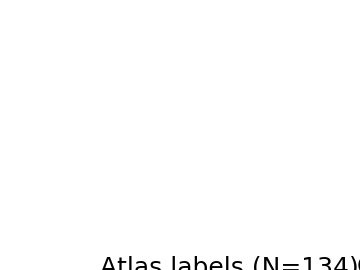

Text(0.5, 1.0, 'Target')

In [9]:
# transform atlas
AI = interp(xI,I,Xs.permute(3,0,1,2),mode='nearest')# note mode=nearest for labels
# contrast
AI0 = AI - torch.mean(AI)
if it == 0:
    Jbar = torch.mean(J)
    J0 = J - Jbar
fAI = AI0 * torch.mean(AI0*J0) / torch.mean(AI0**2) + Jbar
# we will want to update the contrast based on individual labels
fAI = torch.clone(AI)
for l in torch.unique(AI):
    ind = AI==l
    fAI[ind] = torch.mean(J[ind])

f,ax = plt.subplots(1,3)
ax[0].imshow(AI[0][0].detach().cpu()%7)
ax[0].set_title(f'Atlas labels (N={len(torch.unique(AI))})')

ax[1].imshow(fAI[0][0].detach().cpu(),vmin=torch.min(J).item(),vmax=torch.max(J).item())
ax[1].set_title('Contrast transformed')

ax[2].imshow(J[0][0].detach().cpu())
ax[2].set_title('Target')

In [10]:
# create a padded 3D J
Jp = torch.cat((torch.zeros_like(J),J,torch.zeros_like(J)),1)
Op = torch.cat((torch.zeros_like(J),J*0+1,torch.zeros_like(J)),1)
# and need a dz
dz = 500.0
xJp = [torch.tensor([-dz,0.0,dz],device=device,dtype=dtype),xJ[1],xJ[2]]

tensor([[ 1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.9848,  0.1736],
        [ 0.0000, -0.1736,  0.9848]], requires_grad=True) tensor([-2175.,  4000.,  5000.], requires_grad=True)


<IPython.core.display.Javascript object>


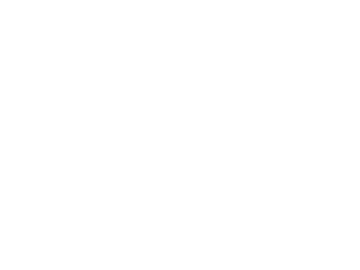

<IPython.core.display.Javascript object>


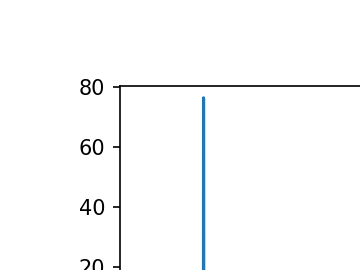

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:123: UserWarning: No contour levels were found within the data range.


In [11]:
nt = 2
v = torch.zeros((nt,nv[0],nv[1],nv[2],3),requires_grad=True)
# affine matrix 
L = torch.eye(3,device=device, dtype=dtype, requires_grad=True)
#L.data[1,1] = -1
L.data[1,1] = np.cos(theta0)
L.data[2,1] = np.sin(theta0)
L.data[1,2] = -np.sin(theta0)
L.data[2,2] = np.cos(theta0)
T = torch.zeros(3,device=device,dtype=dtype, requires_grad=True)
T.data[0] = -xI[0][slice_//2]
T.data[1] = 4000
T.data[2] = 5000
print(L,T)

f0,ax0 = plt.subplots(1,3,sharex=True,sharey=True)
f1,ax1 = plt.subplots(2,2)
ax1 = ax1.ravel()

# optimization
eA = 1e5
eA = 1e4
ev = 5e8*0

start3d = 1000000
startdiff = 800*1000
niter = 3000

sigmaR = 1e9

Esave = []
ERsave = []
Tsave = []
Lsave = []
for it in range(niter):
    
    # generate
    phii = v_to_phii(xv,v.permute(0,4,1,2,3))
    
    
    # apply affine transform to atlas
    A = to_A(L,T)
    # invert
    Ai = torch.inverse(A)
    # sample points
    Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]

    # 
    Xs = (interp(xv,phii-XV.permute(3,0,1,2),Xs.permute(3,0,1,2)) + Xs.permute(3,0,1,2)).permute(1,2,3,0)
    #print('calculated transformation')
    
    
    
    # we need to pull the target back for contrast transform
    if not it%5:
        t0 = time.time()
        with torch.no_grad():
            # transform atlas
            AI = interp(xI,I,Xs.permute(3,0,1,2),mode='nearest') # note mode=nearest for labels
            # this image will only be used for unique labels to speed things up below
    
            phi = v_to_phii(xv,-torch.flip(v.permute(0,4,1,2,3),(0,)))
            Xs__ = (A[:3,:3]@(phi.permute((1,2,3,0)))[...,None])[...,0] + A[:3,-1]
            # right now we are sampling at the points in v, we need to sample at the points in I
            Xs_ = (interp(xv,Xs__.permute(3,0,1,2),XI.permute(3,0,1,2))).permute(1,2,3,0)
            phiiAiJ = interp(xJp,Jp,Xs_.permute(3,0,1,2))
            phiiAiO = interp(xJp,Op,Xs_.permute(3,0,1,2))
            #print('pulled back')
            # now we do a contrast transform with with weights
            fI = torch.clone(I)
            for l in torch.unique(AI[AI>0]): # only do the indices
                # a lot of these are going to give errors
                ind = I==l
                fI[ind] = torch.sum(phiiAiJ[ind])/torch.sum(phiiAiO[ind])            
            fI[torch.isnan(fI)] = 0.0
        t1 = time.time()
        #print(f'time was {t1-t0}')
    
    # now we can transform the atlas
    fAI = interp(xI,fI,Xs.permute(3,0,1,2))
    #print('finished transforming atlas')
    
    
  
   
    # cost
    err = fAI-J
    E = torch.mean(err**2)
    #vhat = torch.rfft(v.permute(0,4,1,2,3),3,onesided=False)
    vhat = torch.fft.fftn(v.permute(0,4,1,2,3),dim=(-1,-2,-3))
    #ER = torch.sum(torch.sum(vhat**2,(0,1,-1))*LL)/torch.prod(nv)*torch.prod(dv)/nt/2.0/sigmaR**2
    ER = torch.sum(torch.sum(torch.abs(vhat)**2,(0,1))*LL)/torch.prod(nv)*torch.prod(dv)/nt/2.0/sigmaR**2
    E = E + ER
    
    E.backward()

    Esave.append(E.item())
    ERsave.append(ER.item())
    Lsave.append(L.detach().clone().cpu().numpy().ravel())
    Tsave.append(T.detach().clone().cpu().numpy().ravel())

    # draw
    if not it%1:
        ax0[0].cla()
        ax0[0].imshow(fAI.detach()[0,0].cpu(),extent=extent,origin='lower',vmin=J.min().item(),vmax=J.max().item())
        ax0[1].cla()
        ax0[1].imshow(J.detach()[0,0].cpu(), extent=extent,origin='lower')    
        ax0[2].cla()
        ax0[2].imshow(err.detach()[0,0].cpu(), extent=extent,origin='lower')

        ax1[0].cla()
        ax1[0].plot(Esave)
        ax1[0].plot(ERsave)
        ax1[1].cla()
        ax1[1].plot(ERsave)
        ax1[2].cla()
        ax1[2].plot(Lsave)
        ax1[3].cla()
        ax1[3].plot(Tsave)

        # it would be good to draw the transform
        levels = torch.arange(-10000.0,10000.0,1000.0,device=device,dtype=dtype)    
        ax0[0].contour(xJ[2].cpu().numpy(),xJ[1].cpu().numpy(),Xs[0,...,0].detach().cpu().numpy(),levels,colors='k',linestyles='-')
        ax0[0].contour(xJ[2].cpu().numpy(),xJ[1].cpu().numpy(),Xs[0,...,1].detach().cpu().numpy(),levels,colors='k',linestyles='-')
        ax0[0].contour(xJ[2].cpu().numpy(),xJ[1].cpu().numpy(),Xs[0,...,2].detach().cpu().numpy(),levels,colors='k',linestyles='-')

        f0.canvas.draw()
        f1.canvas.draw()

    # update
    with torch.no_grad():
        # combine grads
        grad = torch.cat((L.grad,T.grad[:,None]),-1).reshape(12)
        #print(L,T,grad)
        grad = (gi@grad).reshape(3,4)

        if it >= start3d:
            if it == start3d:
                #eL /= 5
                #eT /= 5
                #eA /= 5.0
                eA /= 10.0
            #L -= L.grad*eL
            #T -= T.grad*eT
            L -= grad[:3,:3]*eA
            T -= grad[:3,-1]*eA            
            

        else:            
            #L[1:] -= L.grad[1:]*eL
            #T[1:] -= T.grad[1:]*eT
            L[1:] -= grad[:3,:3][1:]*eA
            T[1:] -= grad[:3,-1][1:]*eA
        L.grad.zero_()
        T.grad.zero_()

        if it > startdiff:
            #vgrad = torch.irfft(torch.rfft(v.grad.permute(0,4,1,2,3),signal_ndim=3,onesided=False)*K[None,None,...,None],signal_ndim=3,onesided=False).permute(0,2,3,4,1)
            vgrad = torch.fft.ifftn(torch.fft.fftn(v.grad.permute(0,4,1,2,3),dim=(-1,-2,-3))*K[None,None],dim=(-1,-2,-3)).permute(0,2,3,4,1).real
            v -= vgrad*ev
        v.grad.zero_()
        # TODO
        # use metric?
        # identifiability issues?

In [12]:
J.max().item()

5.50095272064209

In [13]:
# note dispersion of dentate layer, hippocampal sclerosis in epilepsy
# in dementia cases there was a little dispersion, but not as much as hippocampal sclerosis
# can you see this at the neuroimaging level? hvinters would be surprised
# does AD with epilepsy differ from AD without epilepsy, suggests epileptic variant of AD


In [14]:
# it seems like the gradient is zero when using nearest
# let me try to implement my own interp
# I want to interp, xI,I